In [1]:
import tensorflow as tf

In [26]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


In [27]:
tf.compat.v1.disable_eager_execution()

In [28]:
e = gym.make('CartPole-v0')

# Experience Replay

In [29]:
from collections import namedtuple
from itertools import count
Transition = namedtuple('trans','state action next_state reward done')
class Replaymem(object):
    def __init__(self,cap):
        #kind of like circular queue
        self.cap = cap
        self.rear = 0
        self.mem = []
    def push(self,*s_a_ns_r_d):
        if(len(self.mem)<self.cap):
            self.mem.append(None)
        self.mem[self.rear]=Transition(*s_a_ns_r_d)
        self.rear = (self.rear+1)%self.cap
    def rsample(self,size_of_sample):
        ###TAKING TOO MUCH TIME
        experience = random.sample(self.mem,size_of_sample)
        l = len(experience)    
        buff = []
        for i in range(l):
            a = []
            a.append(experience[i].state)
            a.append(experience[i].action)
            a.append(experience[i].reward)
            a.append(experience[i].next_state)
            a.append(experience[i].done)
            buff.append(np.array(a))
        return np.reshape(np.array(buff),[l,5])
    def size(self):
        return len(self.mem)

In [30]:
class Replay_Buffer():
    def __init__(self,buffer_size):
        self.buffer = []
        self.buffer_size = buffer_size
    def push(self,experience):
        l = len(self.buffer)
        e = len(experience)
        if l + e >= self.buffer_size:
            self.buffer[0:l+e- self.buffer_size] =[]
        self.buffer.extend(experience)
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
    def sample2(self,size):
        return np.reshape(np.array((self.buffer)),[size,5])

# Tensorflow Model

In [31]:
# class tfModel(tf.keras.Model):
#     def __init__(self, num_states, hidden_units, num_actions):
#         super(tfModel, self).__init__()
#         self.input_layer = tf.keras.layers.InputLayer(input_shape=(num_states,))
#         self.hidden_layers = []
#         for i in hidden_units:
#             self.hidden_layers.append(tf.keras.layers.Dense(
#                 i, activation='relu', kernel_initializer='RandomNormal'))
#         self.output_layer = tf.keras.layers.Dense(
#             num_actions,kernel_initializer='RandomNormal')

#     @tf.function
#     def call(self, inputs):
#         #shape of inputs [batch_size,size_of_state]
#         z = self.input_layer(inputs)
#         for layer in self.hidden_layers:
#             z = layer(z)
#         output = self.output_layer(z)
#         #shape of inputs [batch_size,number of actions outputs(2)]
#         return output

# DQN 

In [32]:
import datetime
class DQN():
    def __init__(self,eps,eps_decay,eps_update,hidden_layers,num_episodes,gamma,target_freq,batch_size,Memsize,learning_rate):
        self.eps = eps
        self.hidden_layers = hidden_layers
        self.eps_decay = eps_decay
        self.eps_up = eps_update
        self.NUM_EPISODES = num_episodes
        self.gamma = gamma
        self.target_up = target_freq
        self.batch_size = batch_size
        self.env = gym.make('CartPole-v0')
        self.num_state_size = 4
        self.num_action_size = 2
        self.ReplayMemSize = Memsize
        self.learning_rate = learning_rate
        self.current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        self.log_dir = './logs/dqn/'+'bestfinal'+'/'
        print(self.current_time)
          ##if tf model is used
#         self.PrimaryNet = tfModel(self.num_state_size,self.hidden_layers,self.num_action_size)
#         self.PrimaryNet.compile(optimizer="Adam",loss="mse",metrics=["mae"])
#         self.TargetNet = tfModel(self.num_state_size,self.hidden_layers,self.num_action_size)     
    def Q_network(self):
        
        ### The primary network

        # Initializing primary networks weights and biases
        # All the weights and biases of primary network
        self.x = tf.keras.backend.placeholder(dtype = tf.float32, shape= [None,self.num_state_size,], name = 'input')
        self.hidden_layer1_size = self.hidden_layers[0]
        self.hidden_layer2_size = self.hidden_layers[1]
        self.hidden_layer3_size = 2
        self.primary_weights = {
            'w1' : tf.Variable(np.random.normal(0, 0.01, size = (self.num_state_size, self.hidden_layer1_size)), dtype = tf.float32, name = "primary_weight1" ),
            'b1' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer1_size)), dtype = tf.float32, name = "primary_bias1" ),
            'w2' : tf.Variable(np.random.normal(0, 0.01, size = (self.hidden_layer1_size, self.hidden_layer2_size)), dtype = tf.float32, name = "primary_weight2" ),
            'b2' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer2_size)), dtype = tf.float32, name = "primary_bias2" ),
            'w3' : tf.Variable(np.random.normal(0, 0.01, size = (self.hidden_layer2_size, self.hidden_layer3_size)), dtype = tf.float32, name = "primary_weight3" ),
            'b3' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer3_size)), dtype = tf.float32, name = "primary_bias3" )
        }

        # Defining the primary network
        p_h1 = tf.nn.relu(tf.add(tf.matmul(self.x, self.primary_weights['w1']), self.primary_weights['b1']))
        p_h2 = tf.nn.relu(tf.add(tf.matmul(p_h1, self.primary_weights['w2']), self.primary_weights['b2']))
        # Q value from primary network
        self.Q_primary = tf.add(tf.matmul(p_h2, self.primary_weights['w3']), self.primary_weights['b3'])
        self.Q_main_predict = tf.argmax(self.Q_primary,axis=1)
        ### The target network
        # Initializing target networks weights and biases
        # All the weights and biases of target network
        self.target_weights = {
            'w1' : tf.Variable(np.random.normal(0, 0.01, size = (self.num_state_size, self.hidden_layer1_size)), dtype = tf.float32, name = "target_weight1" ),
            'b1' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer1_size)), dtype = tf.float32, name = "target_bias1" ),
            'w2' : tf.Variable(np.random.normal(0, 0.01, size = (self.hidden_layer1_size, self.hidden_layer2_size)), dtype = tf.float32, name = "target_weight2" ),
            'b2' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer2_size)), dtype = tf.float32, name = "target_bias2" ),
            'w3' : tf.Variable(np.random.normal(0, 0.01, size = (self.hidden_layer2_size, self.hidden_layer3_size)), dtype = tf.float32, name = "target_weight3" ),
            'b3' : tf.Variable(np.random.normal(0, 0, size = (self.hidden_layer3_size)), dtype = tf.float32, name = "target_bias3" )
        }
        # Defining the target network
        t_h1 = tf.nn.relu(tf.add(tf.matmul(self.x, self.target_weights['w1']), self.target_weights['b1']))
        t_h2 = tf.nn.relu(tf.add(tf.matmul(t_h1, self.target_weights['w2']), self.target_weights['b2']))
        # Q value from target network
        self.Q_target = tf.matmul(t_h2, self.target_weights['w3']) + self.target_weights['b3']
        self.maxQ_target = tf.compat.v1.reduce_max(self.Q_target,axis=1)
        ### Loss and optimizer

        # We need to get the Q values for the actions performed so we multiply the 
        # one hot form of action to the Q values predicted from the primary network
        self.action = tf.keras.backend.placeholder(dtype = tf.int32, shape= [None], name = 'actions') 
        self.one_hot_action = tf.one_hot(self.action, self.num_action_size,dtype = tf.float32, name = 'one_hot_action')
        self.predicted = tf.compat.v1.reduce_sum(tf.multiply(self.Q_primary, self.one_hot_action, name = 'predicted'),axis=1)
        # We here get the reward + the output of Q values from target network
        self.expected = tf.keras.backend.placeholder(dtype = tf.float32, shape= [None], name = 'expected')
        # The mse loss        
        self.loss = tf.reduce_sum(tf.square(self.expected - self.predicted))
#         self.loss = tf.losses.mean_squared_error(self.expected, self.predicted)                                                      
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        # optimizer updates the weights so as to decrease the loss, we chose adam optimizer
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(self.loss,global_step=self.global_step)

    def train(self):
        self.session = tf.compat.v1.Session()
        self.session.run(tf.compat.v1.global_variables_initializer())
        self.replay = Replay_Buffer(self.ReplayMemSize)
        summary_writer = tf.compat.v1.summary.FileWriter(self.log_dir)
        summary = tf.compat.v1.Summary()
        total_reward = np.zeros([self.NUM_EPISODES])
        total_steps = 0
        prev100 = []
        self.plot_100 = []
        self.plot = []
        for i in range(self.NUM_EPISODES):
            state = self.env.reset()
            steps = 0
            self.eps = max(0.05,self.eps*self.eps_decay)
            while True:
                action = self.get_action(state)
                next_state,reward,done,_ = self.env.step(action)
                steps+=1
                total_steps+=1
                total_reward[i]+=reward
                ns = np.reshape(next_state,[1,4])
                s = np.reshape(state,[1,4])
                self.replay.push(np.reshape(np.array([s,action,reward,ns,done]),[1,5]))
                if total_steps>self.batch_size:
                      ###Edit when Experience Replay is Removed
#                 if len(self.replay.buffer)==self.batch_size:
#                     mini_batch = self.replay.sample2(self.batch_size)
                    mini_batch = self.replay.sample(self.batch_size)
                    ####FAST UPDATE
                    max_Q = self.session.run(self.maxQ_target,feed_dict={self.x:np.vstack(mini_batch[:,3])})
                    target = mini_batch[:,2]+self.gamma * max_Q * (1-mini_batch[:,4])
                    _,cost= self.session.run([self.optimizer,self.loss],
                                                feed_dict={
                                                    self.x:np.vstack(mini_batch[:,0]),
                                                    self.expected:np.reshape(target,(None)),
                                                    self.action:np.reshape(mini_batch[:,1],(None))})
                     ####Below Custom Update was slow
#                     loss_val = self.update(mini_batch)
                if total_steps%self.target_up ==0:
                    for j in self.primary_weights:
                        self.session.run(tf.compat.v1.assign(self.target_weights[j], self.primary_weights[j]))
                   ###Epsilon Decay Per number of steps did not give good results
#                 if total_steps%self.eps_up ==0:
#                     self.eps *= self.eps_decay
#                     if self.eps < 0.05:
#                         self.eps = 0.05
                state = next_state
                if done or steps >200:
                    break
            if(len(prev100)<100):
                prev100.append(steps)
            else:
                prev100[i%100]=steps
            hey = np.mean(prev100)
            self.plot_100.append(hey)
            self.plot.append(steps)
            print(i,hey)
            summary.value.add(tag = "Average total reward (number of steps per episode)", simple_value = hey)
            summary_writer.add_summary(summary, i)
            if(i%100==0):
                print(hey) 
            if(hey>=195):
                break
    def get_action(self,state):
        if np.random.random()<self.eps:
            return np.random.choice([0,1],p=[0.5,0.5])
        else:
            state = np.expand_dims(state, axis = 0)
            Q_values = self.session.run(self.Q_primary, feed_dict={self.x : state})
            return np.argmax(Q_values)
    def update(self,experience):
        l = len(experience)
        states = [experience[i].state for i in range(l)]
        actions = [experience[i].action for i in range(l)]
        rewards = [experience[i].reward for i in range(l)]
        next_states = [experience[i].next_state for i in range(l)]
        terminals =[experience[i].done for i in range(l)]
        
        for i in range(len(states)):
            expected_val = rewards[i]
            expected_val = np.expand_dims(expected_val, axis = 0)
            
            if not terminals[i]:
                next_states[i] = np.expand_dims(next_states[i], axis = 0)
                expected_val = self.gamma*np.amax(self.session.run(self.Q_target, feed_dict={self.x : next_states[i]}), axis=1) + rewards[i] 

            states[i] = np.expand_dims(states[i], axis = 0)
            actions[i] = np.expand_dims(actions[i], axis = 0)

            _, loss_val = self.session.run([self.optimizer, self.loss], feed_dict={self.x : states[i], self.expected : expected_val, self.action : actions[i]})

        return loss_val
        
        

In [33]:
hidden = 120
# target_freq1 = 200 
target_freq2 = 300
# batch_size1 = 100
batch_size2 = 120
# dqn1 = DQN(0.5,0.99,20,[hidden,hidden],2000,0.9,target_freq1,batch_size1,10000,0.0025)
dqn2 = DQN(0.5,0.99,20,[hidden,hidden],2000,1,target_freq2,batch_size2,10000,0.0001)

20200731-110625


In [34]:
# dqn1.Q_network()
dqn2.Q_network()

# Starting Training 

dqn2

In [36]:
dqn2.train()

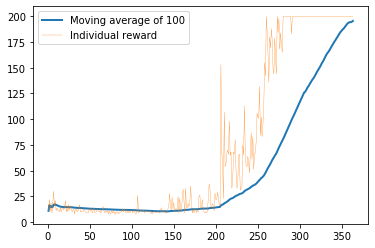

In [17]:

#  with summary_writer.as_default():
#         tf.summary.scalar('episode reward', total_reward, step=n)
#         tf.summary.scalar('running avg reward(100)', avg_rewards, step=n)
#         tf.summary.scalar('average loss)', losses, step=n)
T = []
# num_episode=500
for i in range(len(dqn2.plot)):
    T.append(i+1)
plt.plot(T,dqn2.plot_100,linewidth=2,label= "Moving average of 100")
plt.plot(T,dqn2.plot,linewidth = 0.3,label= "Individual reward")
plt.legend(loc = "upper left")
plt.show()


In [18]:
print("[")
for i in range(len(dqn2.plot)):
    print(dqn2.plot_100[i],end = ",")
print("]")

[
11.0,16.5,14.666666666666666,15.75,14.4,14.833333333333334,17.0,16.875,17.333333333333332,16.7,16.454545454545453,16.083333333333332,15.692307692307692,15.285714285714286,15.2,14.875,14.764705882352942,14.722222222222221,14.578947368421053,14.55,14.857142857142858,14.636363636363637,14.695652173913043,14.5,14.6,14.5,14.555555555555555,14.535714285714286,14.379310344827585,14.3,14.258064516129032,14.0625,14.030303030303031,14.0,13.885714285714286,13.805555555555555,13.783783783783784,13.868421052631579,13.76923076923077,13.7,13.609756097560975,13.523809523809524,13.511627906976743,13.477272727272727,13.4,13.304347826086957,13.212765957446809,13.125,13.122448979591837,13.1,13.058823529411764,13.057692307692308,12.981132075471699,12.944444444444445,12.963636363636363,12.892857142857142,12.842105263157896,12.793103448275861,12.796610169491526,12.766666666666667,12.721311475409836,12.693548387096774,12.634920634920634,12.59375,12.615384615384615,12.651515151515152,12.626865671641792,12.57

In [ ]:
##### TWo networks should be available
##### One for Training and one for Targets

In [ ]:
# BATCH_SIZE = 128
# GAMMA = 0.9
# EPS_START = 0.9
# EPS_END = 0.05
# EPS_DECAY = 200
# TARGET_UPDATE = 10

In [ ]:
# for i in range(1000):
#     episode(e,PolicyNet,TargetNet,epsilon,copy,MEM,min_exp,batch_size)
steps=0

In [ ]:
print("check",episode(e,PolicyNet,TargetNet,0,copy,MEM,min_exp,batch_size))